Selected 265 important features out of 265 total features.



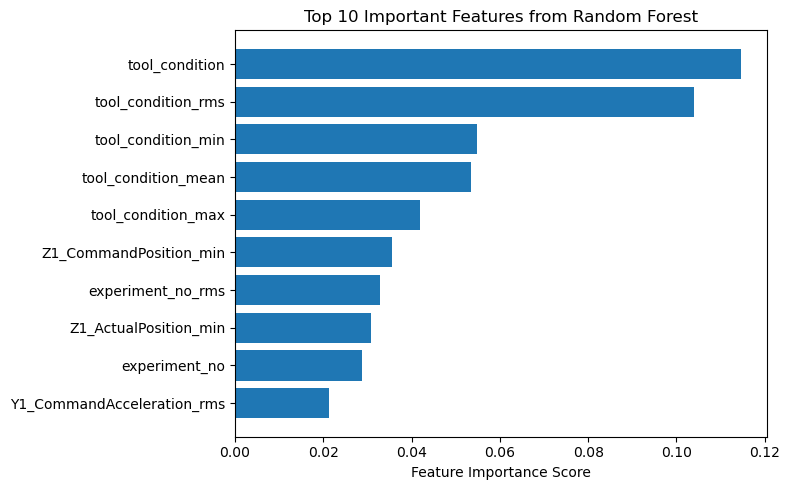


===== Logistic Regression: Tool Wear Prediction =====
              precision    recall  f1-score   support

           0       0.40      0.67      0.50         3
           1       0.00      0.00      0.00         3

    accuracy                           0.33         6
   macro avg       0.20      0.33      0.25         6
weighted avg       0.20      0.33      0.25         6



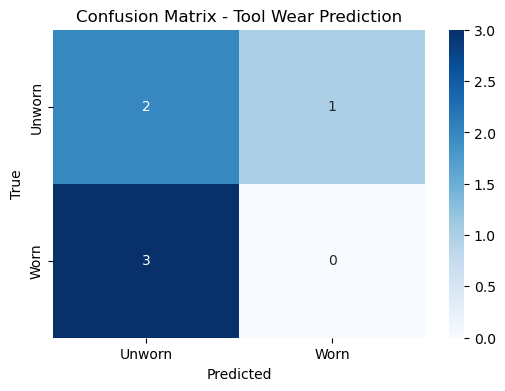


===== Logistic Regression: Clamping Fault Prediction =====
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         1
         1.0       1.00      0.75      0.86         4

    accuracy                           0.80         5
   macro avg       0.75      0.88      0.76         5
weighted avg       0.90      0.80      0.82         5



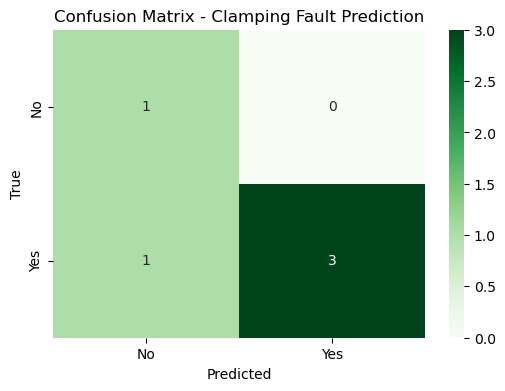

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# Define base path
base_path = r"C:\IIT Courses\Fourth Semester\Data Driven Modeling\Final Project\CNC Mill Tool Wear\archive"

# Loading train.csv
metadata = pd.read_csv(os.path.join(base_path, "train.csv"))
metadata['tool_condition'] = metadata['tool_condition'].map({'unworn': 0, 'worn': 1})
metadata['passed_visual_inspection'] = metadata['passed_visual_inspection'].map({'yes': 1, 'no': 0})

# Loading all experiment files
frames = []
for i in range(1, 19):
    exp_path = os.path.join(base_path, f"experiment_{i:02}.xlsx")
    frame = pd.read_excel(exp_path)
    frame['experiment_no'] = i
    frame['tool_condition'] = metadata.loc[metadata['No'] == i, 'tool_condition'].values[0]
    frame['passed_visual_inspection'] = metadata.loc[metadata['No'] == i, 'passed_visual_inspection'].values[0]
    frame['feedrate'] = metadata.loc[metadata['No'] == i, 'feedrate'].values[0]
    frame['clamp_pressure'] = metadata.loc[metadata['No'] == i, 'clamp_pressure'].values[0]
    frames.append(frame)

df = pd.concat(frames, ignore_index=True)

# ========================== FEATURE ENGINEERING ==========================
def extract_features(df_grouped):
    features = {}
    numeric_cols = df_grouped.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        features[f'{col}_mean'] = df_grouped[col].mean()
        features[f'{col}_std'] = df_grouped[col].std()
        features[f'{col}_min'] = df_grouped[col].min()
        features[f'{col}_max'] = df_grouped[col].max()
        features[f'{col}_rms'] = np.sqrt(np.mean(df_grouped[col] ** 2))
    return features

feature_list = []
for exp_no, group in df.groupby('experiment_no'):
    features = extract_features(group)
    features['experiment_no'] = exp_no
    feature_list.append(features)

features_df = pd.DataFrame(feature_list)

# ========================== MERGE FEATURES WITH LABELS ==========================
full_df = features_df.merge(metadata, left_on='experiment_no', right_on='No')

drop_cols = ['No', 'material', 'machining_finalized']
X = full_df.drop(columns=drop_cols, errors='ignore')
X = X.fillna(0)

# Targets
y_toolwear = full_df['tool_condition']
y_clamp = full_df['passed_visual_inspection']

# ========================== FEATURE SELECTION ==========================
# Random Forest feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y_toolwear)

selector = SelectFromModel(rf, prefit=True, threshold="median")
X_selected = selector.transform(X)
selected_feature_names = X.columns[selector.get_support()]
X_selected_df = pd.DataFrame(X_selected, columns=selected_feature_names)

print(f"Selected {X_selected_df.shape[1]} important features out of {X.shape[1]} total features.\n")

# ========================== FEATURE IMPORTANCE PLOT ==========================
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]
top_features = X.columns[indices]

plt.figure(figsize=(8, 5))
plt.barh(top_features, importances[indices])
plt.xlabel('Feature Importance Score')
plt.title('Top 10 Important Features from Random Forest')
plt.tight_layout()
plt.show()

# ========================== LOGISTIC REGRESSION: TOOL WEAR PREDICTION ==========================
print("\n===== Logistic Regression: Tool Wear Prediction =====")

X_train_tool, X_test_tool, y_train_tool, y_test_tool = train_test_split(
    X_selected_df, y_toolwear, test_size=0.3, random_state=42, stratify=y_toolwear)

model_tool = LogisticRegression(random_state=42)
model_tool.fit(X_train_tool, y_train_tool)

y_pred_tool = model_tool.predict(X_test_tool)

print(classification_report(y_test_tool, y_pred_tool))

# Confusion Matrix Heatmap for Tool Wear
cm_tool = confusion_matrix(y_test_tool, y_pred_tool)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_tool, annot=True, fmt="d", cmap="Blues", xticklabels=["Unworn", "Worn"], yticklabels=["Unworn", "Worn"])
plt.title("Confusion Matrix - Tool Wear Prediction")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ========================== LOGISTIC REGRESSION: CLAMPING FAULT PREDICTION ==========================
print("\n===== Logistic Regression: Clamping Fault Prediction =====")

# Removing NaN rows
mask = ~y_clamp.isna()
X_clamp = X_selected_df[mask]
y_clamp = y_clamp[mask]

X_train_clamp, X_test_clamp, y_train_clamp, y_test_clamp = train_test_split(
    X_clamp, y_clamp, test_size=0.3, random_state=42, stratify=y_clamp)

model_clamp = LogisticRegression(random_state=42)
model_clamp.fit(X_train_clamp, y_train_clamp)

y_pred_clamp = model_clamp.predict(X_test_clamp)

print(classification_report(y_test_clamp, y_pred_clamp))

# Confusion Matrix Heatmap for Clamping Faults
cm_clamp = confusion_matrix(y_test_clamp, y_pred_clamp)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_clamp, annot=True, fmt="d", cmap="Greens", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("Confusion Matrix - Clamping Fault Prediction")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
